# A Missing Data Walkthrough


## Dependencies

This script was executed using the following version of Python:
* **Python 3.6.2 :: Anaconda, Inc.**

Use this link to install Python on your machine:
* https://www.anaconda.com/distribution/#download-section

**About Python Versions:**
If you are running a higher-version of Python and this notebook fails to execute properly, you can downgrade your version in the terminal by running the following commands:
* conda search python [to see which versions are available on your machine]
* conda install python=3.6.2 [which will switch the active version to 3.6.2; if available in the list above]

**About Python Packages:**
All packages used in this notebook can be installed on your machine using the "pip install [package_name]" command on your terminal.  Be sure you've installed each of the packages below before attempting to execute the notebook.

Current package requirements include:
* os - https://docs.python.org/3/library/os.html
* Pandas - https://pandas.pydata.org/
* Datetime - https://docs.python.org/3/library/datetime.html
* re - https://docs.python.org/3/library/re.html
* Numpy - http://www.numpy.org/
* ipywidgets - https://ipywidgets.readthedocs.io/en/stable/user_install.html
* ipython - https://ipython.org/ipython-doc/rel-0.10.2/html/interactive/extension_api.html
* h2o - http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html#install-in-python
* scikit-learn - https://scikit-learn.org/stable/install.html
* requests - https://2.python-requests.org/en/master/user/install/
* io - https://docs.python.org/3/library/io.html
* warnings - https://docs.python.org/3/library/warnings.html
* pandas-profiling - https://github.com/pandas-profiling/pandas-profiling

The current template uses the following versions:
* os== module 'os' from '/anaconda3/lib/python3.6/os.py'
* pandas==0.24.1
* datetime== module 'datetime' from '/anaconda3/lib/python3.6/datetime.py'
* re== module 're' from '/anaconda3/lib/python3.6/re.py'
* numpy==1.16.1
* ipywidgets==7.4.2
* ipython==6.2.1
* h2o==3.24.0.4
* scikit-learn==0.19.1
* requests==2.18.4
* io== module 'io' from '/anaconda3/lib/python3.6/io.py'
* warnings== module 'warnings' from '/anaconda3/lib/python3.6/warnings.py'
* pandas-profiling==2.3.0

## Before you begin, ensure you've installed the required Python packages

* See the list above and make note of the specific versions that were used in this notebook

In [157]:
############################################
###### Import required Python packages #####
############################################

import os
import pandas as pd
import re
import datetime as dt
import numpy as np
from ipywidgets import interact, interactive, IntSlider, Layout
import ipywidgets as widgets
from IPython.display import display
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
import io
import requests
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')

## Note: Code Cells are Hidden by Default for Ease-of-Use

This notebook incorporates interactive "widgets" which will result in large blocks of cells being utilized to enable specific user-interactions.  Executing this cell will hide all "Code" cells while making all outputs visible to the user.  Refer to the link below for the source or simply "run" the block below to see the impact on the rest of the notebook.

* https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

#### Disclaimer:
* As the "output text" notes, simply click the "here" hyperlink in the text to toggle on/off this feature

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 1.0 - Data Ingestion

The series of code blocks below will walk you through the process of mapping to your working directory and uploading your dataset.

## 1.1 - Set Your Working Directory

Your "working directory" is a folder location on your computer that will store files either read-in or written-out by this script.  This code by default will return your current, active directory.  You can change this directory by typing in a specific path into the text box provided.

## AN IMPORTANT NOTE ABOUT INTERACTIVE WIDGETS

This notebook uses interactive widgets to help you make selections and inputs more conveniently.  As you work through this notebook, be sure to follow the steps below to ensure your selections are incorporated in the cells that follow:

#### 1. Run the cell containing the interactive widget(s) to bring them into view
#### 2. Apply your selections and/or inputs to the widgets that appear
#### 3. DO NOT rerun the cell as it will erase your selections and inputs
#### 4. To proceed, simply click on the next cell in the notebook, and Run it

<br/>

In [159]:
set_working_directory = widgets.Text(
    value=os.getcwd(),
    placeholder='/Users/bblanchard006/Desktop/SMU/QTW/Week 10',
    description='Directory:',
    disabled=False,
    layout=Layout(width='50%')
)

display(set_working_directory)

Text(value='/Users/bblanchard006/Desktop/SMU/QTW/Week 10', description='Directory:', layout=Layout(width='50%'…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

After executing the cell above, you can leave the default directory or overwrite the text string that appears with your desired folder directory. **DO NOT execute the cell again after making your update.** The input above will be fed into the following code cell, where it will either successfully map to the new directory or notify you of an error.

In [160]:
try:
    os.chdir(set_working_directory.value)
    print('Changed directory to {}'.format(set_working_directory.value))
except Exception as e:
    print('Failed to change directory')
    print(e)

Changed directory to /Users/bblanchard006/Desktop/SMU/QTW/Week 10


## 1.2 - Upload Your Data (Excel and CSV files)

The function in the code cell below will find, ingest, and format both xlsx and csv files.  This is the dataset with "known" values which will be used to train your models.

In [161]:
########################################
##### Data Ingestion Functions
########################################

def compile_raw_data(filename, tab_names, subfolder, delimiter_char = ',', skip_rows = 0, file_ext = 'xlsx'):
    
    # Inputs: 
    ## filename = 'sample.csv' | 'sample.xlsx' - the filename in the directory (including the extension) 
    ## tab_names = None | ['Sheet1,'Sheet2'] - None for csv; [comma separated list of tab names] for xlsx
    ## subfolder = 'source_data' - string containing the name of a folder in the working directory
    ## delimiter_char = ',' | ';' - None for xlsx
    ## rows to skip = default 0 - Not used for csv; trims the user-defined number of rows from an xlsx
    ## file extension = csv | xlsx
    
    # Description: reads in the workbook; standardizes header names; 
    # Outputs: returns a dictionary of dataframes

    master_data = {}
    if subfolder:
        file_path = subfolder+'/{}'.format(filename)
    else:
        file_path = filename

    if file_ext == 'csv':
        tab_names = [re.sub('.csv','', filename)]

    for tab in tab_names:
        try:
            if file_ext == 'xlsx':
                dframe = pd.read_excel(file_path, tab, skip_rows)
            elif file_ext == 'csv' and delimiter_char == ',':
                dframe = pd.read_csv(file_path, header=0, delimiter=',')
            else:
                dframe = pd.read_csv(file_path, header=0, delimiter=';')
                
            sanitizer = {
                        '$':'USD',
                        '(':' ',
                        ')':' ',
                        '/':' ',
                        '-':' ',
                        ',':' ',
                        '.':' '
            }
                        
            for key, value in sanitizer.items():
                dframe.rename(columns=lambda x: x.replace(key, value), inplace=True)
                
            dframe.rename(columns=lambda x: x.strip(), inplace=True)
            dframe.rename(columns=lambda x: re.sub(' +','_', x), inplace=True)
            
            dframe.columns = map(str.lower, dframe.columns)
            
            master_data.update({tab:dframe})
        except Exception as e:
            master_data.update({tab:'Failed'})
    
    return master_data

The code blocks below enable conditional filtering to support multiple file types. Further instructions are provided below:

**Uploading csv files**

To upload a csv file, complete these steps:
1. Type in your filename along with the extension (ex. sample.csv)
2. Check the 'csv' radio-button
3. Is your file in the main directory or a sub-folder in the directory:
    * Select the "no" radio-button if your file is in your main directory
    * Select the "yes" radio-button to expose a text-box where you can type-in the name of your sub-folder
    
**Uploading xlsx files**

To upload an xlsx file, complete these steps:
1. Type in your filename along with the extension (ex. sample.xlsx)
2. Check the 'xlsx' radio-button
3. Type in the tab-names you'd like to ingest (comma-separated; Sheet1,Sheet2,Sheet3)
4. If the data in your file has leading rows, select how many rows to skip before ingesting the data (ex. if your data starts on Row 2 in the Excel-file, set the Skip Rows value to 1)
5. Is your file in the main directory or a sub-folder in the directory:
    * Select the "no" radio-button if your file is in your main directory
    * Select the "yes" radio-button to expose a text-box where you can type-in the name of your sub-folder

In [162]:
upload_type = widgets.RadioButtons(
    options=['local', 'url'],
    description='File Location:',
    disabled=False
)

upload_url = widgets.Text(
    value='https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv',
    placeholder='http://',
    description='URL:',
    disabled=False,
    layout=Layout(width='80%')
)
upload_filename = widgets.Text(
    value='missing_titanic_data.csv',
#     value='raw_titanic_data.csv'
    placeholder='Sample File.csv',
    description='File Name:',
    disabled=False,
    layout=Layout(width='50%')
)

file_type = widgets.RadioButtons(
    options=['csv', 'xlsx'],
    description='File Type:',
    disabled=False
)

tab_names = widgets.Text(
    value='Sheet1, Sheet2, Sheet3, etc',
    placeholder='ALL EMPLOYEES, PAST EMPLOYEES',
    description='Tab(s):',
    disabled=False,
    layout=Layout(width='50%')
)

subfolder_name = widgets.Text(
    value='source_data',
    placeholder='Subfolder name',
    description='Subfolder:',
    disabled=False,
    layout=Layout(width='50%')
)

subfolder = widgets.RadioButtons(
    options=['no','yes'],
    value='no',
    description='Subfolder:',
    disabled=False
)

skip_rows = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Skip Rows:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

delimiter = widgets.RadioButtons(
    options=[',',';'],
    value=',',
    description='Delimiter:',
    disabled=False
)

def text_field(x):
    if(x=='xlsx'):
        display(tab_names)
        tab_names.on_submit(tab_names)
        display(skip_rows)
    else:
        display(delimiter)
        print('Tab Names: Not needed for csv files')

def sub_folder(y):
    if(y=='yes'):
        display(subfolder_name)
        subfolder_name.on_submit(subfolder_name)
    else:
        print('Using {} folder'.format(os.getcwd()))

def file_location(z):
    if(z=='local'):
        display(upload_filename)
        i = widgets.interactive(text_field, x=file_type)
        display(i)
        p = widgets.interactive(sub_folder, y=subfolder)
        display(p)
    else:
        display(upload_url)
    
q = widgets.interactive(file_location, z=upload_type)

display(q)

interactive(children=(RadioButtons(description='File Location:', options=('local', 'url'), value='local'), Out…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

The following code cell will attempt to ingest the data you've selected in the widgets above:

**Note About xlsx Files** - Depending on the number of tabs and the size of the data on each tab, ingesting an xlsx file can take several minutes to execute.  If possible, it may be more efficient to break your Excel file into separate csv files which take only a fraction of a second to ingest.

In [163]:
master_data = {}

if upload_type.value == 'url':
    url_response = requests.request("GET", upload_url.value)
    master_data['url_data'] = pd.read_csv(io.BytesIO(url_response.content))
else:
    if file_type.value == 'csv':
        tabs = None
        skiprows = 0
    else:
        tabs = [x.strip() for x in tab_names.value.split(',')]
        skiprows = skip_rows.value

    if subfolder.value == 'yes':
        subfolder = subfolder_name.value
    else:
        subfolder = None
    master_data = compile_raw_data(upload_filename.value, tabs, subfolder, delimiter_char = delimiter.value, skip_rows = skiprows, file_ext = file_type.value)


**Note:** If you see an AttributeError: 'NoneType' object has no attribute 'value' message above, simply rerun the last two code cells to reset the input parameters.

The following code cell will print out the attributes associated with the files you've uploaded and alert you of any errors:

In [164]:
for key, value in master_data.items():
    try:
        print('{} table was ingested with {} rows and {} columns'.format(key,value.shape[0],value.shape[1]))
    except:
        print('{} table failed to load'.format(key))

missing_titanic_data table was ingested with 887 rows and 11 columns


## 1.3 - Select a Data Frame

The following menus will allow you to select the dataset you would like to use in your modeling and the variables you would like included in the subsequent processes.  You can preview a sample of the data as well as increase or decrease the number of records returned by using the integer input widget (which has a default range; minimum rows = 1, maximum rows = 50).

Select an available frame from the list below:

In [165]:
dict_keys = widgets.Select(
    options=master_data.keys(),
    description='Tables:',
    disabled=False,
    layout=Layout(width='50%')
)

display(dict_keys)

Select(description='Tables:', layout=Layout(width='50%'), options=('missing_titanic_data',), value='missing_ti…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

After selecting a frame above, select the variables you would like included in your workflow from the list below:

**NOTE:** To select multiple values from the picklist, either hold down the command key on your keyboard or click and hold the shift key to select ranges of variables.  You can scroll down if your mouse is within the widget window.

In [166]:
review_variables = widgets.SelectMultiple(
    options=master_data[dict_keys.value].columns.tolist(),
    description='Variables:',
    disabled=False
)

display(review_variables)

SelectMultiple(description='Variables:', options=('index_id', 'survived', 'passenger_class', 'name', 'sex', 'a…

In [167]:
master_data[dict_keys.value].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index_id                 887 non-null    object 
 1   survived                 882 non-null    float64
 2   passenger_class          845 non-null    float64
 3   name                     887 non-null    object 
 4   sex                      827 non-null    object 
 5   age                      824 non-null    float64
 6   siblings_spouse_aboard   814 non-null    float64
 7   parents_children_aboard  830 non-null    float64
 8   purchase_fare            798 non-null    float64
 9   original_fare_value      887 non-null    float64
 10  total_passengers         797 non-null    float64
dtypes: float64(8), object(3)
memory usage: 76.4+ KB


## Run Pandas-Profiling to Quickly Summarize the Dataset

The following cell will create a pandas-profiling report on your selected dataset.  Use the menu labels that appear in the top-right portion of the report to quickly view "Correlations" and "Missing values" embedded in your data.  For variables that are found to be highly correlated, inspect the missing value proportions of each variable and see if one is more complete than the other (this may be an effective way for eliminating variables that have high concentrations of missing values).

In [168]:
profile_report = master_data[dict_keys.value].profile_report(title="Dataset Report")
profile_report

The cell below allows you to dynamically select a range of rows to view from your dataset.

In [169]:
review_var_list = []
for i in review_variables.value:
    review_var_list.append(i)
    
master_data['custom_table'] = master_data[dict_keys.value][review_var_list]

head_number = widgets.BoundedIntText(
    value=5,
    min=1,
    max=50,
    step=1,
    description='Rows:',
    disabled=False
)

def sample_view(head_number):
    sample = master_data['custom_table'].head(head_number)
    print(sample)

out = widgets.interactive_output(sample_view, {'head_number':head_number})

widgets.VBox([widgets.VBox([head_number]), out])

## 2.0 - Train Models

The following widgets allow a user to choose a dataframe, select a subset of variables to groupby, and build appropriate datatype aggregations (ex. counts for categorical fields; summary statistics for numerical fields).  The function below does not require editing if being applied to another notebook (however, it can be extended to include additional transformations as needed).

## 2.1 - Select Your Target Variable

Your "Target" variable represents the thing you are attempting to predict. It should be either "categorical" (ex. text, labels) or "continuous" (ex. numeric values) in nature. The target and its type will impact which algorithms are used and the evaluation metrics that are useful in evaluating each models' performance.

Select your Target variable and note whether or not it is a categorical or continuous data type:

In [170]:
target = widgets.Select(
    options=master_data['custom_table'].columns.tolist(),
    description='Target',
    disabled=False
)

target_type = widgets.Select(
    options=['Continuous','Categorical'],
    description='Type',
    disabled=False,
)

display(target)
display(target_type)

Select(description='Target', options=('index_id', 'survived', 'passenger_class', 'name', 'sex', 'age', 'siblin…

Select(description='Type', options=('Continuous', 'Categorical'), value='Continuous')

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

## 2.2 - Initiate H2O

The code cell below will terminate any existing h2o instances and create a new instance

In [173]:
try:
    h2o.cluster().shutdown()
    h2o.init()
except:
    h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6k/j123vpgj42xf7z7vhxmc8bsw0000gn/T/tmpz5qeahsu
  JVM stdout: /var/folders/6k/j123vpgj42xf7z7vhxmc8bsw0000gn/T/tmpz5qeahsu/h2o_bblanchard006_started_from_python.out
  JVM stderr: /var/folders/6k/j123vpgj42xf7z7vhxmc8bsw0000gn/T/tmpz5qeahsu/h2o_bblanchard006_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.4
H2O cluster version age:,"1 year, 1 month and 9 days !!!"
H2O cluster name:,H2O_from_python_bblanchard006_b4bqc7
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## IMPORTANT: If you are rerunning this workflow and have not "restarted your kernel" you will need to run the "cell" above up to three times to clear the instances.

**DO NOT PROCEED UNTIL** the above cell contains the following text (which will be visible just above a summary table):

Connecting to H2O server at http://127.0.0.1:54321 ... successful.

Load your dataset into h2o by running the command below

In [174]:
df = master_data['custom_table'].dropna(subset=[target.value])
df = h2o.H2OFrame(df, destination_frame='automl_modeling_data')

Parse progress: |█████████████████████████████████████████████████████████| 100%


Once the "Parse progress:" reaches 100% above, confirm that your dataset has been loaded correctly by reviewing the table below

In [175]:
df.describe()

Rows:882
Cols:11




,index_id,survived,passenger_class,name,sex,age,siblings_spouse_aboard,parents_children_aboard,purchase_fare,original_fare_value,total_passengers
type,string,int,int,string,enum,real,int,int,real,real,int
mins,NaN,0.0,1.0,NaN,,0.42,0.0,0.0,0.0,0.0,1.0
mean,NaN,0.3854875283446712,2.2928571428571414,NaN,,29.63207570207572,0.521631644004945,0.39104116222760293,32.90959886506937,37.221180952380955,1.9191919191919176
maxs,NaN,1.0,3.0,NaN,,80.0,8.0,6.0,512.3292,614.795,11.0
sigma,NaN,0.4869864247978144,0.8413885048177824,NaN,,14.055933405553418,1.11130077551079,0.8199731736931057,50.98518146291652,57.75473745213024,1.63357173563308
zeros,0,542,0,0,,0,551,625,12,15,0
missing,0,0,42,0,0,63,73,56,89,0,90
0,ri_000001,0.0,3.0,Mr. Owen Harris Braund,male,22.0,nan,0.0,7.25,8.6275,2.0
1,ri_000002,1.0,1.0,Mrs. John Bradley (Florence Briggs Thayer) Cumings,nan,38.0,1.0,0.0,71.2833,81.263,2.0
2,ri_000003,1.0,3.0,Miss. Laina Heikkinen,nan,26.0,0.0,0.0,7.925,9.3515,nan


If your "Target" variable is categorical, the code below will convert it to a factor before modeling

In [176]:
if target_type.value == 'Categorical':
    df[target.value] = df[target.value].asfactor()

## 2.3 - Configure Models

The parameters below can be left in their default settings or modified to meet your specific requirements.

### Important Note about Missing Values:
If your data has columns with missing values, the pre-selected algorithms in the menu below (i.e., XGBoost and GBM) do not impute missing values by default.  Use these modeling types to create a baseline model and to determine which variables might be important before engineering processes for missing values.

In [177]:
sample_type = widgets.RadioButtons(
    options=['Train | Test', 'Cross Validation', 'Use Data Field'],
    description='Sampling:',
    disabled=False
)

train_perc = widgets.FloatSlider(
    value=.70,
    min=.50,
    max=.80,
    step=.01,
    description='Train %:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)

nfolds = widgets.IntSlider(
    value=3,
    min=3,
    max=10,
    step=1,
    description='CV Folds:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

project_name = widgets.Text(
    value='My Project Name',
    placeholder='My Project Name',
    description='Project:',
    disabled=False,
    layout=Layout(width='50%')
)

include_algos = widgets.SelectMultiple(
    options=['DRF','GLM','XGBoost','GBM','DeepLearning','StackedEnsemble'],
    value=['XGBoost','GBM'],
    description='Include:',
    disabled=False,
)


ignore_vars = master_data['custom_table'].columns.tolist()
ignore_vars.remove(target.value)

ignore_cols = widgets.SelectMultiple(
    options=ignore_vars,
    description='Ignore:',
    disabled=False,
)

specify_algos = widgets.RadioButtons(
    options=['Select from list','Use defaults'],
    description='Algorithms:',
    disabled=False
)

run_time_mins = widgets.IntSlider(
    value=1,
    min=1,
    max=60,
    step=1,
    description='Run (min):',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def algo_select(x):
    if(x=='Select from list'):
        display(include_algos)
    else:
        print('Using all available algorithms')

def sampling(x):
    if(x=='Train | Test'):
        display(train_perc)
    elif (x=='Cross Validation'):
        display(nfolds)
        print('Train %: Not needed for Cross Validation')
    else:
        display(sample_fields)
        print('Sampling field to be selected in the next cell')

        
sample_fields = widgets.Select(
    options=master_data['custom_table'].columns.tolist(),
    description='Sample on:',
    disabled=False
)

def sample_labels(x):
    train_label = widgets.Select(
        options=master_data['custom_table'][x].unique().tolist(),
        description='Train Label:',
        disabled=False
    )

    display(train_label)

f = widgets.interactive(sampling, x=sample_type)
g = widgets.interactive(algo_select, x=specify_algos)

display(project_name,f,g,ignore_cols,run_time_mins)
print('The Run (min) value will determine how long the process builds models')

Text(value='My Project Name', description='Project:', layout=Layout(width='50%'), placeholder='My Project Name…

interactive(children=(RadioButtons(description='Sampling:', options=('Train | Test', 'Cross Validation', 'Use …

interactive(children=(RadioButtons(description='Algorithms:', options=('Select from list', 'Use defaults'), va…

SelectMultiple(description='Ignore:', options=('index_id', 'passenger_class', 'name', 'sex', 'age', 'siblings_…

IntSlider(value=1, description='Run (min):', max=60, min=1)

The Run (min) value will determine how long the process builds models


## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

If you have already included a field to separate your data into a training and testing set, please select which label in the field should be used as your training data.  All other labels will be assigned to the testing set.

In [178]:
def sample_by_field(Method):
    if(Method=='Use Data Field'):
        display(sample_field_label_value)
    else:
        print('Using h2o.ai sampling procedure')
       
sample_field_label_value = widgets.Select(
    options=master_data['custom_table'][sample_fields.value].unique().tolist(),
    description='Train on:',
    disabled=False
)

print("If you have already created a sampling field in your dataset, please select the label that designates your training data")
b = widgets.interactive(sample_by_field, Method=sample_type.value)

display(b)


If you have already created a sampling field in your dataset, please select the label that designates your training data


interactive(children=(Text(value='Train | Test', description='Method'), Output()), _dom_classes=('widget-inter…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed
The code below will compile the settings you have selected above into the H2OAutoML function

In [179]:
if sample_type.value == 'Train | Test':
    cv_folds = 0
    splits = df.split_frame(ratios = [train_perc.value], seed = 1, destination_frames=['automl_train_data','automl_test_data'])
    train = splits[0]
    test = splits[1]
elif sample_type.value == 'Use Data Field':
    cv_folds = 0
    train = df[df[sample_fields.value] == sample_field_label_value.value]
    train = train.drop(sample_fields.value)
    test = df[df[sample_fields.value] != sample_field_label_value.value]
    test = test.drop(sample_fields.value)
else:
    cv_folds = nfolds.value

min_to_secs = run_time_mins.value*60    

algo_list = [x for x in include_algos.value]

ignored_vars = [x for x in ignore_cols.value]
keep_vars = [x for x in master_data['custom_table'].columns if x not in ignored_vars]


if specify_algos.value == 'Use defaults':
    aml = H2OAutoML(max_runtime_secs = min_to_secs, seed = 1, project_name = project_name.value, nfolds=cv_folds)
else:
    aml = H2OAutoML(max_runtime_secs = min_to_secs, seed = 1, project_name = project_name.value, include_algos = algo_list, nfolds=cv_folds)


## 2.4 - Automatically Train Models

The code below will automatically generate as many models as possible within the time you have permitted.  If you have selected "Cross Validation" as your "Sampling" method above, note that the entire dataset will be used in modeling bby leveraging the "CV Folds" (Cross Validation Folds) you have entered.

**NOTE:** This process will run for the number of minutes you have selected above and may provide different results if run iteratively based on the time it takes for specific algorithms to train.

In [180]:
if sample_type.value == 'Cross Validation':
    aml.train(y = target.value, training_frame = df[keep_vars])
else:
    aml.train(y = target.value, training_frame = train[keep_vars], validation_frame = test[keep_vars], leaderboard_frame = test[keep_vars])
    
    

AutoML progress: |████████████████████████████████████████████████████████| 100%


Once the cell above shows 100%, executing the code cell below will show the "leaderboard" based on the specific evaluation metric you have selected to rank

**Ranking:** The ranking defaults to AUC for binary classification, mean_per_class_error for multinomial classification, and deviance for regression.

In [181]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20200708_192248_model_19,0.870101,0.428297,0.182684,0.366304,0.134178
GBM_grid_1_AutoML_20200708_192248_model_6,0.866955,0.432212,0.193939,0.367189,0.134828
GBM_grid_1_AutoML_20200708_192248_model_2,0.86355,0.520339,0.187879,0.40968,0.167837
GBM_grid_1_AutoML_20200708_192248_model_17,0.86202,0.430338,0.205195,0.368219,0.135585
GBM_2_AutoML_20200708_192248,0.861645,0.427955,0.192208,0.365335,0.13347
GBM_3_AutoML_20200708_192248,0.859221,0.433204,0.190909,0.367424,0.135
GBM_grid_1_AutoML_20200708_192248_model_18,0.858644,0.439735,0.193074,0.370908,0.137573
GBM_4_AutoML_20200708_192248,0.85824,0.43656,0.2,0.370367,0.137172
GBM_grid_1_AutoML_20200708_192248_model_8,0.85697,0.438357,0.182251,0.368487,0.135783
GBM_1_AutoML_20200708_192248,0.856392,0.439888,0.189177,0.371194,0.137785


The following code returns a summary of the top performing model (per the leaderboard above) and how it performed on either the full dataset (if Cross Validation was selected) or the test dataset (if a training set was used during modeling)

In [182]:
if sample_type.value == 'Cross Validation':
    eval_results = aml.leader.model_performance()
else:
    eval_results = aml.leader.model_performance(test)
    
print(eval_results)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13417842582588405
RMSE: 0.3663037343870303
LogLoss: 0.4282970596802994
Mean Per-Class Error: 0.18268398268398267
AUC: 0.87010101010101
pr_auc: 0.8425442282030471
Gini: 0.7402020202020201
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5086032206596212: 


,0,1,Error,Rate
0,155.0,10.0,0.0606,(10.0/165.0)
1,32.0,73.0,0.3048,(32.0/105.0)
Total,187.0,83.0,0.1556,(42.0/270.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5086032,0.7765957,81.0
max f2,0.1952800,0.8086957,152.0
max f0point5,0.5747584,0.8396947,70.0
max accuracy,0.5086032,0.8444444,81.0
max precision,0.9769259,1.0,0.0
max recall,0.0417045,1.0,262.0
max specificity,0.9769259,1.0,0.0
max absolute_mcc,0.5086032,0.6705000,81.0
max min_per_class_accuracy,0.3472946,0.7939394,115.0
max mean_per_class_accuracy,0.5086032,0.8173160,81.0


Gains/Lift Table: Avg response rate: 38.89 %, avg score: 37.06 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0111111,0.9595427,2.5714286,2.5714286,1.0,0.9694013,1.0,0.9694013,0.0285714,0.0285714,157.1428571,157.1428571
,2,0.0222222,0.9503188,2.5714286,2.5714286,1.0,0.9535239,1.0,0.9614626,0.0285714,0.0571429,157.1428571,157.1428571
,3,0.0333333,0.9479508,2.5714286,2.5714286,1.0,0.9491089,1.0,0.9573447,0.0285714,0.0857143,157.1428571,157.1428571
,4,0.0407407,0.9411323,2.5714286,2.5714286,1.0,0.9457243,1.0,0.9552319,0.0190476,0.1047619,157.1428571,157.1428571
,5,0.0518519,0.9311987,2.5714286,2.5714286,1.0,0.9362188,1.0,0.9511577,0.0285714,0.1333333,157.1428571,157.1428571
,6,0.1,0.8422389,2.5714286,2.5714286,1.0,0.9006289,1.0,0.9268290,0.1238095,0.2571429,157.1428571,157.1428571
,7,0.1518519,0.7427191,2.2040816,2.4459930,0.8571429,0.7841241,0.9512195,0.8781005,0.1142857,0.3714286,120.4081633,144.5993031
,8,0.2,0.6688930,2.1758242,2.3809524,0.8461538,0.6978637,0.9259259,0.8347102,0.1047619,0.4761905,117.5824176,138.0952381
,9,0.3,0.5257222,2.0,2.2539683,0.7777778,0.5963845,0.8765432,0.7552683,0.2,0.6761905,100.0,125.3968254
,10,0.4,0.4060779,0.8571429,1.9047619,0.3333333,0.4564800,0.7407407,0.6805712,0.0857143,0.7619048,-14.2857143,90.4761905


If you would like to investigate the parameters that were used by the model or would like to review any other method associated with the model,  please select from the the list below.

**NOTE:** Not all methods may be relevant to all algorithms. If you would like to print a plot of your important variables, select the "varimp_plot" if available in the list.  You can also print the standardized coefficients using the "std_coef_plot" method if listed.

In [183]:
all_methods = dir(aml.leader)
keep_methods = [x for x in all_methods if not x.startswith('_')]

methods = widgets.Select(
    options=keep_methods,
    description='Method:',
    disabled=False
)

display(methods)

Select(description='Method:', options=('F0point5', 'F1', 'F2', 'accuracy', 'actual_params', 'aic', 'algo', 'au…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed
After making your selection above, the results will display as appropriate in the cell below:

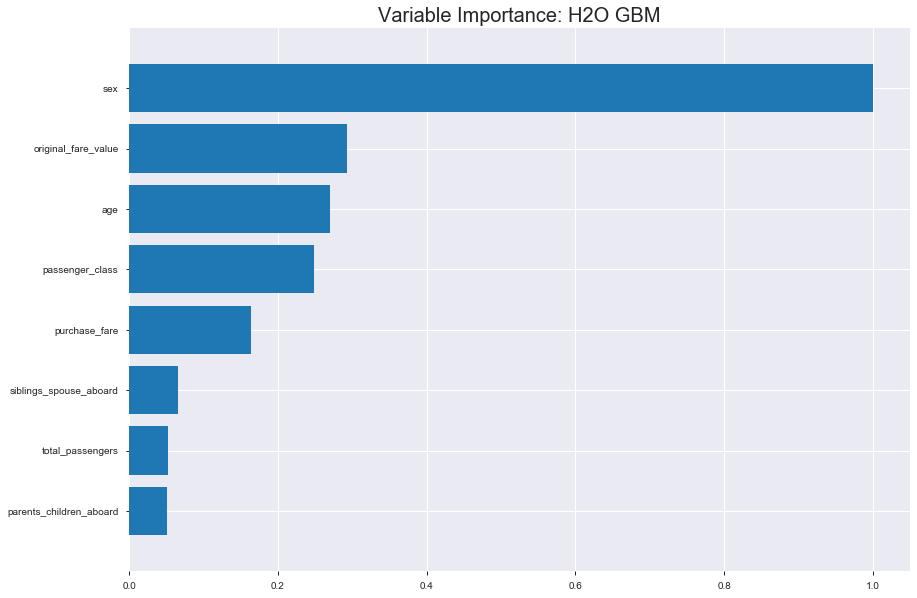

varimp_plot: None


In [187]:
try:
    print('{}: {}'.format(methods.value, eval('aml.leader.'+methods.value+'()')))
except:
    print('{}: {}'.format(methods.value, eval('aml.leader.'+methods.value)))

### Score your existing dataset with the top model

The code below will apply predicted-values to your full dataset should you wish to evaluate the results against the historical results.

**Note:** This is different than if you want to apply your model against new data (which we will cover in the section to follow).

In [188]:
prediction_frame = aml.leader.predict(df)
full_data_with_predictions = df.cbind(prediction_frame)
full_data_with_predictions

gbm prediction progress: |████████████████████████████████████████████████| 100%


index_id,survived,passenger_class,name,sex,age,siblings_spouse_aboard,parents_children_aboard,purchase_fare,original_fare_value,total_passengers,predict,p0,p1
ri_000001,0,3,Mr. Owen Harris Braund,male,22,nan,0,7.25,8.6275,2,0,0.908037,0.0919629
ri_000002,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cumings,nan,38,1,0,71.2833,81.263,2,1,0.282156,0.717844
ri_000003,1,3,Miss. Laina Heikkinen,nan,26,0,0,7.925,9.3515,nan,0,0.80472,0.19528
ri_000004,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,nan,63.72,2,1,0.0364372,0.963563
ri_000005,0,3,Mr. William Henry Allen,nan,nan,0,0,nan,8.9355,1,0,0.546652,0.453348
ri_000006,0,3,Mr. James Moran,nan,27,nan,0,8.4583,9.6425,1,0,0.812426,0.187574
ri_000007,0,1,Mr. Timothy J McCarthy,male,nan,nan,0,51.8625,57.0488,1,0,0.540549,0.459451
ri_000008,0,3,Master. Gosta Leonard Palsson,nan,2,nan,1,21.075,24.8685,5,1,0.459964,0.540036
ri_000009,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,nan,0,2,11.1333,12.358,3,1,0.319083,0.680917
ri_000010,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,nan,nan,0,30.0708,33.3786,2,1,0.0888822,0.911118


## 3.0 - Make Predictions & Export Results

The following process will walk you through uploading another dataset to score against your top model.

**Note:** The new dataset must contain the same fields that were used to train your models in the prior steps.  The structure of the new dataset does not have to be consistent with the one used in prior steps (ex. there is no need to align columns or remove fields).

## 3.1 - Upload Your Data (Excel and CSV files)

Follow the same process you used in subsequent steps to upload the dataset you would like to apply against your trained model.  This is the dataset with "unknown" values which your trained models will attempt to predict.

In [189]:
upload_type = widgets.RadioButtons(
    options=['local', 'url'],
    description='File Location:',
    disabled=False
)

upload_url = widgets.Text(
    value='https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv',
    placeholder='http://',
    description='URL:',
    disabled=False,
    layout=Layout(width='80%')
)
upload_filename = widgets.Text(
    value='raw_titanic_data.csv',
    placeholder='Sample File.csv',
    description='File Name:',
    disabled=False,
    layout=Layout(width='50%')
)

file_type = widgets.RadioButtons(
    options=['csv', 'xlsx'],
    description='File Type:',
    disabled=False
)

tab_names = widgets.Text(
    value='Sheet1, Sheet2, Sheet3, etc',
    placeholder='ALL EMPLOYEES, PAST EMPLOYEES',
    description='Tab(s):',
    disabled=False,
    layout=Layout(width='50%')
)

subfolder_name = widgets.Text(
    value='source_data',
    placeholder='Subfolder name',
    description='Subfolder:',
    disabled=False,
    layout=Layout(width='50%')
)

subfolder = widgets.RadioButtons(
    options=['no','yes'],
    value='no',
    description='Subfolder:',
    disabled=False
)

skip_rows = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Skip Rows:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

delimiter = widgets.RadioButtons(
    options=[',',';'],
    value=',',
    description='Delimiter:',
    disabled=False
)

def text_field(x):
    if(x=='xlsx'):
        display(tab_names)
        tab_names.on_submit(tab_names)
        display(skip_rows)
    else:
        display(delimiter)
        print('Tab Names: Not needed for csv files')

def sub_folder(y):
    if(y=='yes'):
        display(subfolder_name)
        subfolder_name.on_submit(subfolder_name)
    else:
        print('Using {} folder'.format(os.getcwd()))

def file_location(z):
    if(z=='local'):
        display(upload_filename)
        i = widgets.interactive(text_field, x=file_type)
        display(i)
        p = widgets.interactive(sub_folder, y=subfolder)
        display(p)
    else:
        display(upload_url)

q = widgets.interactive(file_location, z=upload_type)

display(q)

interactive(children=(RadioButtons(description='File Location:', options=('local', 'url'), value='local'), Out…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed
The following code cell will attempt to ingest the data you've selected in the widgets above:

**Note About xlsx Files** - Depending on the number of tabs and the size of the data on each tab, ingesting an xlsx file can take several minutes to execute.  If possible, it may be more efficient to break your Excel file into separate csv files which take only a fraction of a second to ingest.

In [190]:
new_data = {}

if upload_type.value == 'url':
    url_response = requests.request("GET", upload_url.value)
    new_data['url_data'] = pd.read_csv(io.BytesIO(url_response.content))
else:
    if file_type.value == 'csv':
        tabs = None
        skiprows = 0
    else:
        tabs = [x.strip() for x in tab_names.value.split(',')]
        skiprows = skip_rows.value

    if subfolder.value == 'yes':
        subfolder = subfolder_name.value
    else:
        subfolder = None
    new_data = compile_raw_data(upload_filename.value, tabs, subfolder, delimiter_char = delimiter.value, skip_rows = skiprows, file_ext = file_type.value)


**Note:** If you see an AttributeError: 'NoneType' object has no attribute 'value' message above, simply rerun the last two code cells to reset the input parameters.

The following code cell will print out the attributes associated with the files you've uploaded and alert you of any errors:

In [191]:
for key, value in new_data.items():
    try:
        print('{} table was ingested with {} rows and {} columns'.format(key,value.shape[0],value.shape[1]))
    except:
        print('{} table failed to load'.format(key))

raw_titanic_data table was ingested with 887 rows and 11 columns


## 3.2 - Select a Data Frame to be Scored

The following menus will allow you to select the dataset you would like to score against your trained model.  This dataset should contain the fields you used to train the models in prior steps, but it does not have to consistent of the same structure (ex. there is no need to remove unused columns or align column locations).

Select an available frame from the list below:

In [192]:
dict_keys = widgets.Select(
    options=new_data.keys(),
    description='Tables:',
    disabled=False,
    layout=Layout(width='50%')
)

display(dict_keys)

Select(description='Tables:', layout=Layout(width='50%'), options=('raw_titanic_data',), value='raw_titanic_da…

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed

## If using the default Titanic dataset
The code cell below will pull the index rows in from the h2o training and testing frames to generate training and testing frames on the full dataset.

In [193]:
try:
    train_df=train.as_data_frame(use_pandas=True, header=True)
    train_ids = train_df['index_id'].tolist()

    new_train_df = new_data[dict_keys.value][new_data[dict_keys.value]['index_id'].isin(train_ids)]
    new_test_df = new_data[dict_keys.value][~new_data[dict_keys.value]['index_id'].isin(train_ids)]

    new_training = h2o.H2OFrame(new_train_df, destination_frame='non_missing_training_data')
    new_testing = h2o.H2OFrame(new_test_df, destination_frame='non_missing_testing_data')
except:
    pass

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [194]:
score_data = h2o.H2OFrame(new_data[dict_keys.value], destination_frame=dict_keys.value)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## 3.3 - Predict the Target Value

The code below will attempt to apply your trained model against this new dataset and predict the target value.  The result will be a new dataset with your original data combined with the predicted results.

In [37]:
prediction_frame = aml.leader.predict(score_data)
full_data_with_predictions = score_data.cbind(prediction_frame)
full_data_with_predictions

gbm prediction progress: |████████████████████████████████████████████████| 100%


index_id,survived,passenger_class,name,sex,age,siblings_spouse_aboard,parents_children_aboard,purchase_fare,original_fare_value,total_passengers,predict,p0,p1
ri_000001,0,3,Mr. Owen Harris Braund,male,22,1,0,7.25,8.6275,2,0,0.897666,0.102334
ri_000002,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cumings,female,38,1,0,71.2833,81.263,2,1,0.0567186,0.943281
ri_000003,1,3,Miss. Laina Heikkinen,female,26,0,0,7.925,9.3515,1,0,0.526741,0.473259
ri_000004,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,53.1,63.72,2,1,0.0376114,0.962389
ri_000005,0,3,Mr. William Henry Allen,male,35,0,0,8.05,8.9355,1,0,0.893408,0.106592
ri_000006,0,3,Mr. James Moran,male,27,0,0,8.4583,9.6425,1,0,0.8755,0.1245
ri_000007,0,1,Mr. Timothy J McCarthy,male,54,0,0,51.8625,57.0488,1,0,0.746406,0.253594
ri_000008,0,3,Master. Gosta Leonard Palsson,male,2,3,1,21.075,24.8685,5,0,0.859783,0.140217
ri_000009,1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27,0,2,11.1333,12.358,3,0,0.497486,0.502514
ri_000010,1,2,Mrs. Nicholas (Adele Achem) Nasser,female,14,1,0,30.0708,33.3786,2,1,0.141946,0.858054


In [38]:
new_data['scored_data'] = full_data_with_predictions.as_data_frame(use_pandas=True)

## 3.4 - Export Dataframes for Offline Analysis

The following code block will allow you to select and export dataframes to a local directory.  Use the inputs below to write the files to your current directory and to apply a timestamp to the filenames to prevent the risk of overwriting prior files saved to that folder.

In [39]:
def dict_to_csv(dict_name, dframe, subfolder, timestamp = False):
    
    # Inputs: a dictionary of dataframes; timestamp = True adds an ISO-formatted suffix to the filename
    # Description: Writes dataframes contained within a dictionary to CSV (on your directory)

    if subfolder:
        file_path = subfolder+'/'
        suffix = '_' + re.sub(r"\:+", '', dt.datetime.now().isoformat()) + '.csv' if timestamp else '.csv'  
        file_path = os.path.join(file_path, dframe + suffix)
    else:
        suffix = '_' + re.sub(r"\:+", '', dt.datetime.now().isoformat()) + '.csv' if timestamp else '.csv'  
        file_path = os.path.join(dframe + suffix)
        
    try:
        dict_name[dframe].to_csv(file_path, sep=',', encoding='utf-8', index = False)
        print('Successfully wrote {} with {} rows and {} columns to the directory'.format(dframe+suffix, new_data[dframe].shape[0], new_data[dframe].shape[1]))
    except Exception as e:
        print('Writing the data to the directory failed')
        

Select one or more available dataframes, then select whether or not you'd like the files saved to the current working directory or a subfolder in the directory.  Lastly, if you would like a timestamp to be added to your exported filenames, select Timestamp = 'yes' to prevent overwriting prior files saved to the folder.

## The scored_data table in the widget below contains both the raw data you uploaded along with the predicted values resulting from your model

In [40]:
dict_keys = widgets.SelectMultiple(
    options=new_data.keys(),
    description='Tables:',
    disabled=False,
    layout=Layout(width='50%')
)

display(dict_keys)

subfolder_option = widgets.RadioButtons(
    options=['no','yes'],
    value='no',
    description='Subfolder:',
    disabled=False
)

timestamp_option = widgets.RadioButtons(
    options=['no','yes'],
    value='yes',
    description='Timestamp:',
    disabled=False
)

subfolder_text = widgets.Text(
    value='output',
    placeholder='Subfolder name',
    description='Subfolder:',
    disabled=False,
    layout=Layout(width='50%')
)

def sub_folder_edit(y):
    if(y=='yes'):
        display(subfolder_text)
        subfolder_text.on_submit(subfolder_text)
        print('Your file(s) will be written to the subfolder in {}'.format(os.getcwd()+os.sep+subfolder_text.value))
    else:
        print('Using {} folder'.format(os.getcwd()))
        
y = widgets.interactive(sub_folder_edit, y=subfolder_option)

display(y, timestamp_option)

SelectMultiple(description='Tables:', layout=Layout(width='50%'), options=('raw_titanic_data', 'scored_data'),…

interactive(children=(RadioButtons(description='Subfolder:', options=('no', 'yes'), value='no'), Output()), _d…

RadioButtons(description='Timestamp:', index=1, options=('no', 'yes'), value='yes')

## Reminder: Do not rerun the cell above after applying your inputs

### Click on and Run this cell to proceed
Execute the code cell below to export the csv files to your chosen directory.

**NOTE:** If you have chosen to write your files to a "subfolder" - ensure that the folder can be found in your working directory.  The function below will "not create a subfolder" in your directory.

In [41]:
if subfolder_option.value == 'yes':
    subfolder = subfolder_text.value
else:
    subfolder = None
    
dframe_list = []
for df in dict_keys.value:
    dframe_list.append(df)

if timestamp_option.value == 'yes':
    timestamp_boolean = True
else:
    timestamp_boolean = False
 
for df in dframe_list:
    dict_to_csv(new_data, df, subfolder, timestamp = timestamp_boolean)

Successfully wrote scored_data_2020-07-07T160638.169619.csv with 887 rows and 14 columns to the directory


## Extract & Save Your Model

Executing the cell below will save a copy of your h2o model:

In [42]:
model_path = h2o.save_model(model=aml.leader, force=True)
print('The model has been successfully saved in the following directory: {}'.format(model_path))
h2o.cluster().shutdown()

The model has been successfully saved in the following directory: /Users/bblanchard006/Desktop/SMU/QTW/Week 10/GBM_grid_1_AutoML_20200707_160336_model_19
H2O session _sid_8e95 closed.


#### If you need any support,  please feel free to contact me at bablanchard@smu.edu

In [122]:
h2o.cluster().shutdown()

H2O session _sid_b665 closed.
